# Sentiment Analysis - Natural Language Processing

### Import necessary libraries

In [1]:
# Dataframe
import pandas as pd

# Array
import numpy as np
import itertools

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
import gensim
import re


import unicodedata
tokenizer = ToktokTokenizer()
nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [2]:
%run "C:/users/eturk/Data_Science/Capstone_Project-Sentiment_Analysis/Data_Storytelling/contractions.py"

### Reading the Cleaned Dataset

In [3]:
# Read the file
df2 = pd.read_csv('C:/users/eturk/Data_Science/Capstone_Project-Sentiment_Analysis/dataset/cleaned_dataset.csv')

In [4]:
# Sample observations
df2.sample(3)

,customer,product,review_text,rating_class,year,clean_text,tokens
14196,ABL3PCYAQ1Y4C,B00AFBSIPI,"Rollers are great, clips are iffy I'm a longti...",good,2013,roller great clip iffy longtime user hot rolle...,"['roller', 'great', 'clip', 'iffy', 'longtime'..."
3301,A2POEZE9CZ7J7C,B003156NFW,WOW Wow what a wonderful product..... Self Ma...,good,2010,wow wow wonderful product self magazine turn i...,"['wow', 'wow', 'wonderful', 'product', 'self',..."
5500,A1MQ7QN3S90UJ3,B005IHS8KY,"Wow, is all I have to say! Okay, seriously, wh...",good,2012,wow say okay seriously would not want brush se...,"['wow', 'say', 'okay', 'seriously', 'would', '..."


In [5]:
# Compressed the dataset to 400 observations 
df2 = df2[df2['year']==2013][:400]

# Natural Language Processing

## 1. Feature Engineering and Selection

Machine Learning models take numerical values as input. Our dataset is a list of sentences, so in order for our algorithm to extract patterns from the data, we first need to find a way to represent it in a way that our algorithm can understand, i.e. as a list of numbers. 

We will implement CounterVectorizer, Tf-Idf, Word2Vec, adding most common words into the stopwords list, SMOTE technique, and PCA technique into the our models in the following sections as a part of feature engineering and selection.

## 2. Data Preprocessing

**Separating Response Variable and Feature**

In [6]:
df2['rating_class'] = df2['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [7]:
# Splitting the Data Set into Train and Test Sets
X = df2['clean_text']
y = df2['rating_class']

**Splitting Dataset into Train and Test Set**

We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data. 

In [8]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
# Print train and test set shape
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(300,)
Test Set Shape		:(100,)


## 3. Selecting the Right Evaluation Metric

As the data imbalance is emphasized above, the evaluation of the classifier performance must be carried out using adequate metrics in order to take into account the class distribution and to pay more attention to the minority class. When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall. For our particular case, based on this thought I will use f1 score which is harmonic average of precision and recall as my evaluation metric.

**Confusion Matrix Plot Function**

A first step is to understand the types of errors our model makes, and which kind of errors are least desirable. A good way to visualize this information is using a Confusion Matrix, which compares the predictions our model makes with the true label. Ideally, the matrix would be a diagonal line from top left to bottom right (our predictions match the truth perfectly).

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.summer):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [11]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

## 4. Modelling 

This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by females who bought beauty products in Amazon e-commerce system.  We used Python’s Scikit Learn libraries to solve our problem. In this context, we implemented Logistic Regression, Linear SVM and Random Forest, Gradient Boosting, XGBOOST, Naive Bayes and Catboost algorithm. 

Since the ratings of the reviews were not distributed normally, we decided to decrease rating classes from 5 to 3 by merging Rating 1-2 as ‘Bad’ and Rating 4-5 as Good while keeping Rating 3 is out of our model. 

In this section, we will try combinations of different vectorizer and models to get the prediction scores for classification. 

Due to the computation capacity limitations and in order to overcome error interruptions; models have been run one by one. Under normal conditions, reducing iterations with pipelines and loops will be more practical.

## 4.1 CounterVectorizer Bag of Words

Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.

In order to address this, scikit-learn provides utilities for the most common ways to extract numerical features from text content, namely:

- **tokenizing** strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.

- **counting** the occurrences of tokens in each document.

- **normalizing** and weighting with diminishing importance tokens that occur in the majority of samples / documents.

In this scheme, features and samples are defined as follows:

- each **individual token occurrence frequency** (normalized or not) is treated as a feature.

- the vector of all the token frequencies for a given **document** is considered a multivariate sample.
A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

**"CountVectorizer"** implements both tokenization and occurrence counting in a single class. 

In [12]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [13]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 2679


In [14]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [15]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns = vocab).head()

,ability,able,absence,absolutely,absorb,absorbed,abuse,access,accessory,accidentally,...,yay,year,yes,yet,young,yr,yuck,yummy,zero,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Creating a function for applying different algorithms**

In [16]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))

### 4.1.1 Logistic Regression with CountVectorizer

In [17]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',
                                     class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.8448863636363636


**Classification Report**

In [18]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.56      0.33      0.42        15
           1       0.89      0.95      0.92        85

   micro avg       0.86      0.86      0.86       100
   macro avg       0.72      0.64      0.67       100
weighted avg       0.84      0.86      0.84       100



**Confusion Matrix**

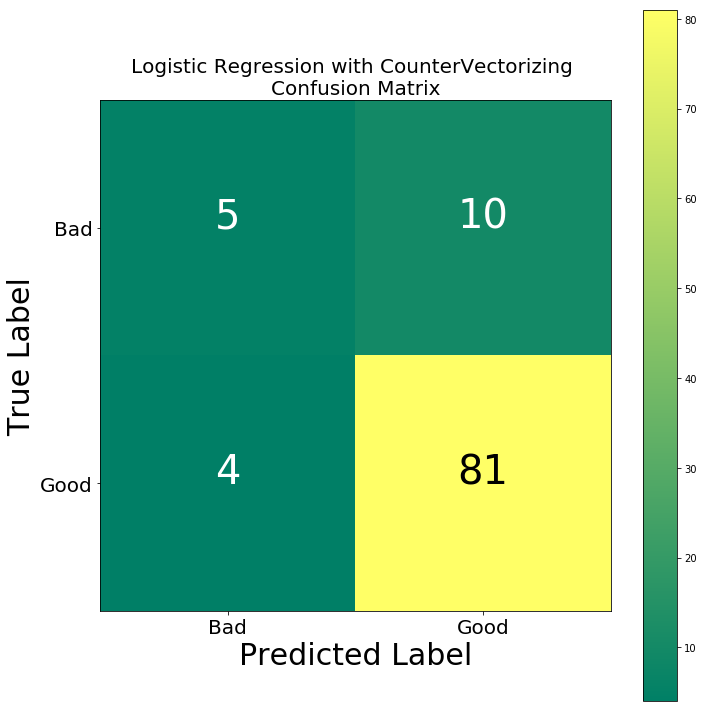

In [19]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

### 4.1.2 Random Forest with CountVectorizer

In [20]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.781081081081081


**Classification Report**

In [21]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.85      1.00      0.92        85

   micro avg       0.85      0.85      0.85       100
   macro avg       0.42      0.50      0.46       100
weighted avg       0.72      0.85      0.78       100



**Confusion Matrix**

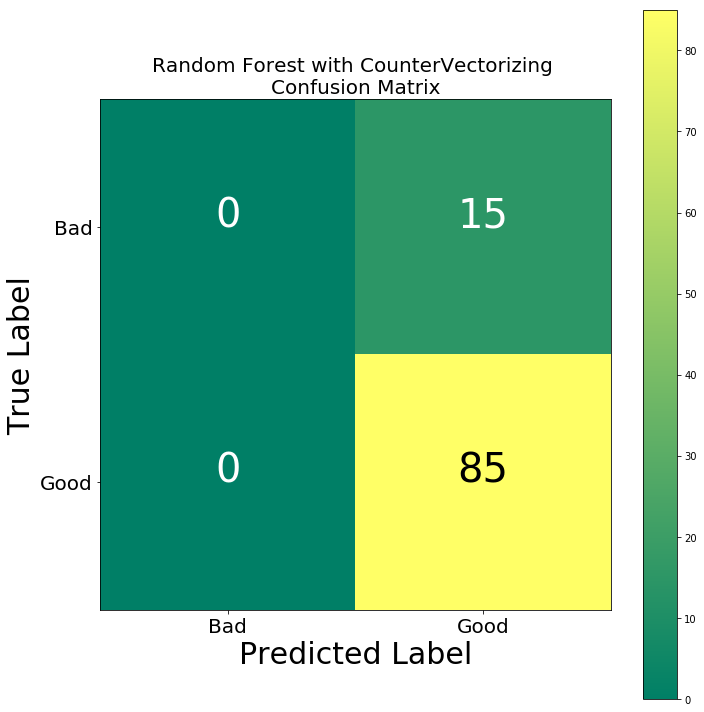

In [22]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest")

### 4.1.3 Naive Bayes with CountVectorizer 

In [23]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.781081081081081


**Classification Report**

In [24]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.85      1.00      0.92        85

   micro avg       0.85      0.85      0.85       100
   macro avg       0.42      0.50      0.46       100
weighted avg       0.72      0.85      0.78       100



**Confusion Matrix**

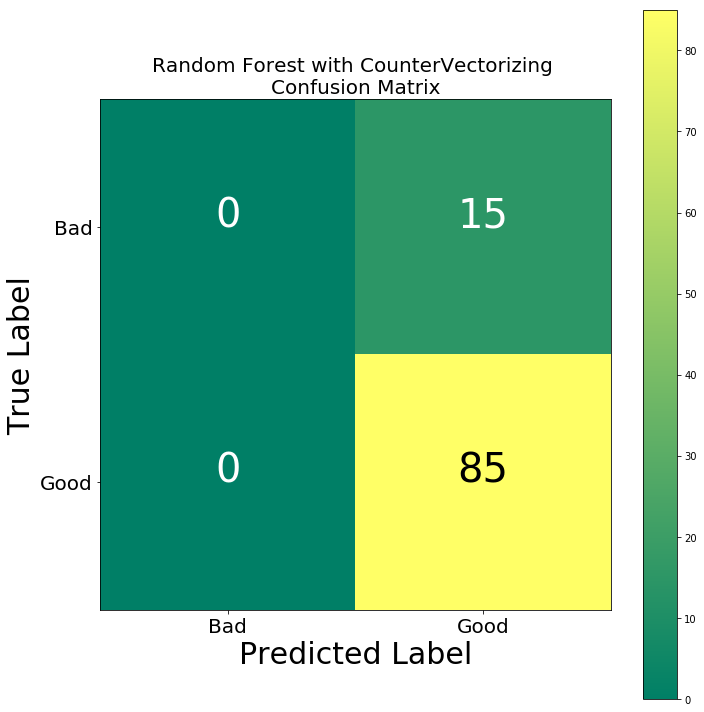

In [25]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Random Forest")

### 4.1.4 XGBoost with CountVectorizing

In [26]:
# Call the modeling function for XGBoost with countvectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

f1 score: 0.791941391941392


**Classification Report**

In [27]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.33      0.07      0.11        15
           1       0.86      0.98      0.91        85

   micro avg       0.84      0.84      0.84       100
   macro avg       0.59      0.52      0.51       100
weighted avg       0.78      0.84      0.79       100



**Confusion Matrix**

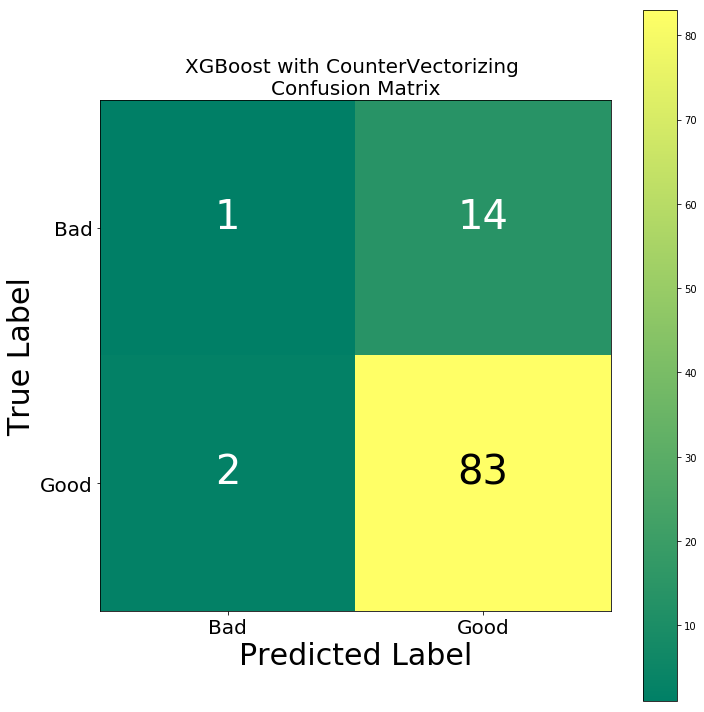

In [28]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost")

### 4.1.5 CatBoosting with CountVectorizing

In [29]:
# Call the modeling function for CatBoost with countvectorizer and print f1 score
modeling(CatBoostClassifier(iterations=1000, learning_rate=0.8, 
                            depth=2, loss_function='Logloss'))

# Assign y_pred to a variable for further process
y_pred_cv_catboost = y_pred

0:	learn: 0.3964707	total: 237ms	remaining: 3m 56s
1:	learn: 0.3494310	total: 276ms	remaining: 2m 17s
2:	learn: 0.3332335	total: 317ms	remaining: 1m 45s
3:	learn: 0.3115986	total: 357ms	remaining: 1m 28s
4:	learn: 0.3099836	total: 398ms	remaining: 1m 19s
5:	learn: 0.2899099	total: 436ms	remaining: 1m 12s
6:	learn: 0.2849903	total: 478ms	remaining: 1m 7s
7:	learn: 0.2727854	total: 519ms	remaining: 1m 4s
8:	learn: 0.2652530	total: 559ms	remaining: 1m 1s
9:	learn: 0.2505136	total: 599ms	remaining: 59.3s
10:	learn: 0.2363041	total: 639ms	remaining: 57.5s
11:	learn: 0.2210474	total: 679ms	remaining: 55.9s
12:	learn: 0.2089351	total: 719ms	remaining: 54.6s
13:	learn: 0.2081656	total: 759ms	remaining: 53.4s
14:	learn: 0.2059277	total: 799ms	remaining: 52.5s
15:	learn: 0.2003024	total: 839ms	remaining: 51.6s
16:	learn: 0.1977867	total: 878ms	remaining: 50.7s
17:	learn: 0.1904682	total: 917ms	remaining: 50s
18:	learn: 0.1749891	total: 957ms	remaining: 49.4s
19:	learn: 0.1652172	total: 1s	remain

161:	learn: 0.0150274	total: 6.63s	remaining: 34.3s
162:	learn: 0.0135991	total: 6.67s	remaining: 34.2s
163:	learn: 0.0132717	total: 6.7s	remaining: 34.2s
164:	learn: 0.0131903	total: 6.74s	remaining: 34.1s
165:	learn: 0.0129920	total: 6.78s	remaining: 34.1s
166:	learn: 0.0129467	total: 6.81s	remaining: 34s
167:	learn: 0.0126512	total: 6.85s	remaining: 33.9s
168:	learn: 0.0125080	total: 6.89s	remaining: 33.9s
169:	learn: 0.0123590	total: 6.92s	remaining: 33.8s
170:	learn: 0.0123293	total: 6.96s	remaining: 33.8s
171:	learn: 0.0121289	total: 7s	remaining: 33.7s
172:	learn: 0.0120755	total: 7.03s	remaining: 33.6s
173:	learn: 0.0120698	total: 7.07s	remaining: 33.6s
174:	learn: 0.0120572	total: 7.1s	remaining: 33.5s
175:	learn: 0.0117159	total: 7.15s	remaining: 33.5s
176:	learn: 0.0115471	total: 7.19s	remaining: 33.4s
177:	learn: 0.0114053	total: 7.23s	remaining: 33.4s
178:	learn: 0.0113949	total: 7.27s	remaining: 33.3s
179:	learn: 0.0113884	total: 7.31s	remaining: 33.3s
180:	learn: 0.01135

320:	learn: 0.0050798	total: 12.5s	remaining: 26.5s
321:	learn: 0.0050742	total: 12.6s	remaining: 26.5s
322:	learn: 0.0050295	total: 12.6s	remaining: 26.4s
323:	learn: 0.0050188	total: 12.6s	remaining: 26.4s
324:	learn: 0.0050031	total: 12.7s	remaining: 26.3s
325:	learn: 0.0049948	total: 12.7s	remaining: 26.3s
326:	learn: 0.0049887	total: 12.8s	remaining: 26.2s
327:	learn: 0.0049857	total: 12.8s	remaining: 26.2s
328:	learn: 0.0049831	total: 12.8s	remaining: 26.2s
329:	learn: 0.0049760	total: 12.9s	remaining: 26.1s
330:	learn: 0.0049688	total: 12.9s	remaining: 26.1s
331:	learn: 0.0049659	total: 12.9s	remaining: 26s
332:	learn: 0.0049524	total: 13s	remaining: 26s
333:	learn: 0.0049417	total: 13s	remaining: 25.9s
334:	learn: 0.0049337	total: 13s	remaining: 25.9s
335:	learn: 0.0049311	total: 13.1s	remaining: 25.9s
336:	learn: 0.0049310	total: 13.1s	remaining: 25.8s
337:	learn: 0.0049285	total: 13.2s	remaining: 25.8s
338:	learn: 0.0048953	total: 13.2s	remaining: 25.7s
339:	learn: 0.0048927	

479:	learn: 0.0034894	total: 18.3s	remaining: 19.8s
480:	learn: 0.0034847	total: 18.3s	remaining: 19.8s
481:	learn: 0.0034820	total: 18.4s	remaining: 19.7s
482:	learn: 0.0034819	total: 18.4s	remaining: 19.7s
483:	learn: 0.0034812	total: 18.4s	remaining: 19.6s
484:	learn: 0.0034803	total: 18.5s	remaining: 19.6s
485:	learn: 0.0034803	total: 18.5s	remaining: 19.6s
486:	learn: 0.0034754	total: 18.5s	remaining: 19.5s
487:	learn: 0.0034714	total: 18.6s	remaining: 19.5s
488:	learn: 0.0034710	total: 18.6s	remaining: 19.4s
489:	learn: 0.0034709	total: 18.6s	remaining: 19.4s
490:	learn: 0.0034697	total: 18.7s	remaining: 19.4s
491:	learn: 0.0034689	total: 18.7s	remaining: 19.3s
492:	learn: 0.0034673	total: 18.7s	remaining: 19.3s
493:	learn: 0.0034038	total: 18.8s	remaining: 19.2s
494:	learn: 0.0033986	total: 18.8s	remaining: 19.2s
495:	learn: 0.0033951	total: 18.9s	remaining: 19.2s
496:	learn: 0.0033936	total: 18.9s	remaining: 19.2s
497:	learn: 0.0033935	total: 19s	remaining: 19.1s
498:	learn: 0.

638:	learn: 0.0025006	total: 24s	remaining: 13.6s
639:	learn: 0.0024995	total: 24.1s	remaining: 13.5s
640:	learn: 0.0024982	total: 24.1s	remaining: 13.5s
641:	learn: 0.0024954	total: 24.1s	remaining: 13.5s
642:	learn: 0.0024902	total: 24.2s	remaining: 13.4s
643:	learn: 0.0024735	total: 24.2s	remaining: 13.4s
644:	learn: 0.0024672	total: 24.2s	remaining: 13.3s
645:	learn: 0.0024660	total: 24.3s	remaining: 13.3s
646:	learn: 0.0024649	total: 24.3s	remaining: 13.3s
647:	learn: 0.0024648	total: 24.3s	remaining: 13.2s
648:	learn: 0.0024567	total: 24.4s	remaining: 13.2s
649:	learn: 0.0024566	total: 24.4s	remaining: 13.1s
650:	learn: 0.0024554	total: 24.4s	remaining: 13.1s
651:	learn: 0.0024539	total: 24.5s	remaining: 13.1s
652:	learn: 0.0024518	total: 24.5s	remaining: 13s
653:	learn: 0.0024510	total: 24.6s	remaining: 13s
654:	learn: 0.0024468	total: 24.6s	remaining: 13s
655:	learn: 0.0024457	total: 24.6s	remaining: 12.9s
656:	learn: 0.0024429	total: 24.7s	remaining: 12.9s
657:	learn: 0.002440

797:	learn: 0.0020851	total: 29.8s	remaining: 7.55s
798:	learn: 0.0020801	total: 29.9s	remaining: 7.52s
799:	learn: 0.0020787	total: 29.9s	remaining: 7.48s
800:	learn: 0.0020783	total: 30s	remaining: 7.44s
801:	learn: 0.0020753	total: 30s	remaining: 7.41s
802:	learn: 0.0020753	total: 30s	remaining: 7.37s
803:	learn: 0.0020752	total: 30.1s	remaining: 7.33s
804:	learn: 0.0020752	total: 30.1s	remaining: 7.29s
805:	learn: 0.0020752	total: 30.1s	remaining: 7.26s
806:	learn: 0.0020752	total: 30.2s	remaining: 7.22s
807:	learn: 0.0020752	total: 30.2s	remaining: 7.18s
808:	learn: 0.0020568	total: 30.2s	remaining: 7.14s
809:	learn: 0.0020560	total: 30.3s	remaining: 7.1s
810:	learn: 0.0020546	total: 30.3s	remaining: 7.07s
811:	learn: 0.0020546	total: 30.4s	remaining: 7.03s
812:	learn: 0.0020546	total: 30.4s	remaining: 6.99s
813:	learn: 0.0020537	total: 30.4s	remaining: 6.95s
814:	learn: 0.0020537	total: 30.5s	remaining: 6.91s
815:	learn: 0.0020537	total: 30.5s	remaining: 6.88s
816:	learn: 0.00205

956:	learn: 0.0017425	total: 36s	remaining: 1.61s
957:	learn: 0.0017423	total: 36s	remaining: 1.58s
958:	learn: 0.0017420	total: 36s	remaining: 1.54s
959:	learn: 0.0017419	total: 36.1s	remaining: 1.5s
960:	learn: 0.0017412	total: 36.1s	remaining: 1.47s
961:	learn: 0.0017412	total: 36.2s	remaining: 1.43s
962:	learn: 0.0017411	total: 36.2s	remaining: 1.39s
963:	learn: 0.0017401	total: 36.2s	remaining: 1.35s
964:	learn: 0.0017396	total: 36.3s	remaining: 1.32s
965:	learn: 0.0017231	total: 36.3s	remaining: 1.28s
966:	learn: 0.0017227	total: 36.4s	remaining: 1.24s
967:	learn: 0.0017221	total: 36.4s	remaining: 1.2s
968:	learn: 0.0017220	total: 36.4s	remaining: 1.17s
969:	learn: 0.0017214	total: 36.5s	remaining: 1.13s
970:	learn: 0.0016927	total: 36.5s	remaining: 1.09s
971:	learn: 0.0016909	total: 36.6s	remaining: 1.05s
972:	learn: 0.0016909	total: 36.6s	remaining: 1.01s
973:	learn: 0.0016904	total: 36.7s	remaining: 978ms
974:	learn: 0.0016900	total: 36.7s	remaining: 941ms
975:	learn: 0.001687

**Classification Report**

In [30]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.30      0.20      0.24        15
           1       0.87      0.92      0.89        85

   micro avg       0.81      0.81      0.81       100
   macro avg       0.58      0.56      0.57       100
weighted avg       0.78      0.81      0.79       100



**Confusion Matrix**

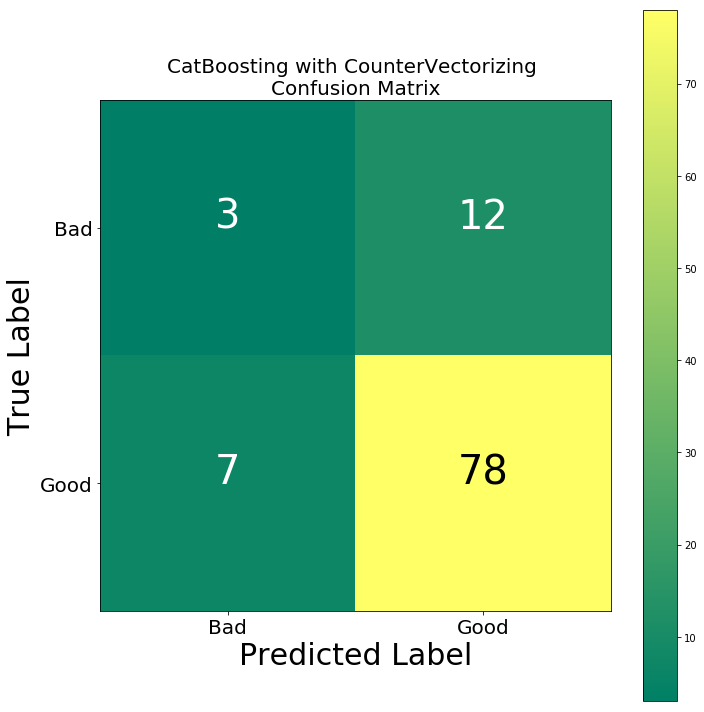

In [31]:
# Print confusion matrix for CatBoost with countVectorizer
disp_confusion_matrix(y_pred_cv_catboost, "CatBoosting")

### 4.1.6 Comparison of CountVectorizing

**Functions for Algorithms Comparison**

In [32]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [33]:
#For loop for using "comparison functions" on "CountVectorizing" results

frames_cv = [] # empty list for collecting dataframes
y_preds_cv = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, 
              y_pred_cv_xgb, y_pred_cv_catboost] #list for y_preds
labels_cv = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'] # list for labels
vector_cv = 'CountVect'
for y_pred, label in zip(y_preds_cv, labels_cv):
    df = comparison_matrix(y_test, y_pred, label, vector_cv)
    frames_cv.append(df)

# concatenating all dataframes
df_cv = pd.concat(frames_cv)

df_cv2 = df_cv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

**Function for f1 Score Plotting**

In [34]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

**Algorithms Comparison with CountVectorizing**

In [35]:
df_cv2

precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.86     bad       0.555556  0.333333  0.416667   
                                  good      0.890110  0.952941  0.920455   
                                  average   0.839927  0.860000  0.844886   
           Random Forest 0.85     bad       0.000000  0.000000  0.000000   
                                  good      0.850000  1.000000  0.918919   
                                  average   0.722500  0.850000  0.781081   
           Naive Bayes   0.85     bad       0.000000  0.000000  0.000000   
                                  good      0.850000  1.000000  0.918919   
                                  average   0.722500  0.850000  0.781081   
           XGBoost       0.84     bad       0.333333  0.066667  0.111111   
                                  good      0.855670  0.976471  0.912088   
                                  average   0.777320  0.840000  0.791941   
           CatBoost      0.81     bad       0.300000  0.200000  0.240000   
                                  good      0.866667  0.917647  0.891429   
                                  average   0.781667  0.810000  0.793714   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.86     bad         15.0  
                                  good        85.0  
                                  average    100.0  
           Random Forest 0.85     bad         15.0  
                                  good        85.0  
                                  average    100.0  
           Naive Bayes   0.85     bad         15.0  
                                  good        85.0  
                                  average    100.0  
           XGBoost       0.84     bad         15.0  
                                  good        85.0  
                                  average    100.0  
           CatBoost      0.81     bad         15.0  
                                  good        85.0  
                                  average    100.0

**Average f1 Score - CountVectorizing**

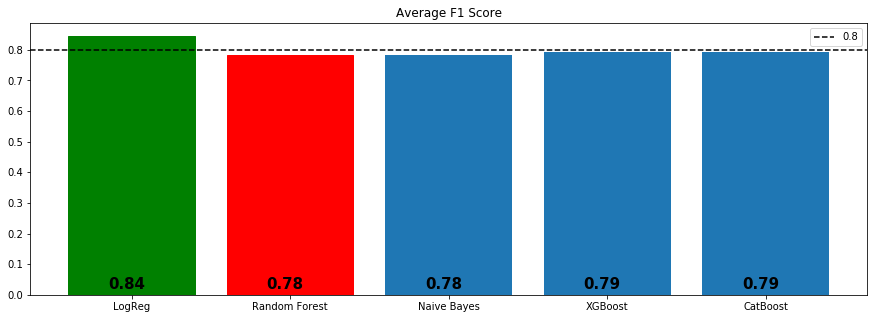

In [36]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_cv, category='average', title= "Average F1 Score")

## 4.2 TF-IDF Bag of Words 

In order to help our model focus more on meaningful words, we can use a TF-IDF score (Term Frequency, Inverse Document Frequency) on top of our Bag of Words model. TF-IDF weighs words by how rare they are in our dataset, discounting words that are too frequent and just add to the noise.

In [37]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

### 4.2.1 Logistic Regression with TF-IDF

In [38]:
# Call the modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

f1 score: 0.850839964633068


**Classification Report**

In [39]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.55      0.40      0.46        15
           1       0.90      0.94      0.92        85

   micro avg       0.86      0.86      0.86       100
   macro avg       0.72      0.67      0.69       100
weighted avg       0.85      0.86      0.85       100



**Confusion Matrix**

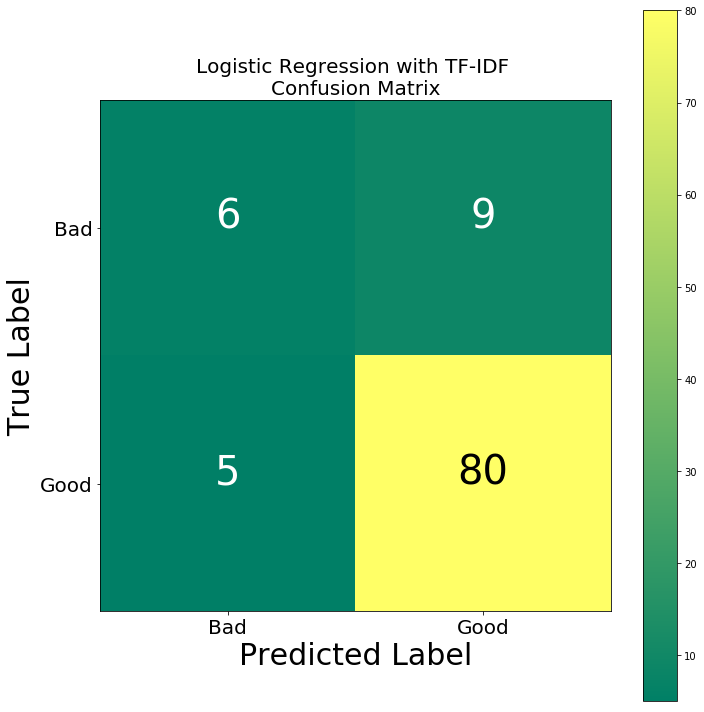

In [40]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

### 4.2.2 Random Forest with TF-IDF

In [44]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

f1 score: 0.781081081081081


**Classification Report**

In [45]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.85      1.00      0.92        85

   micro avg       0.85      0.85      0.85       100
   macro avg       0.42      0.50      0.46       100
weighted avg       0.72      0.85      0.78       100



**Confusion Matrix**

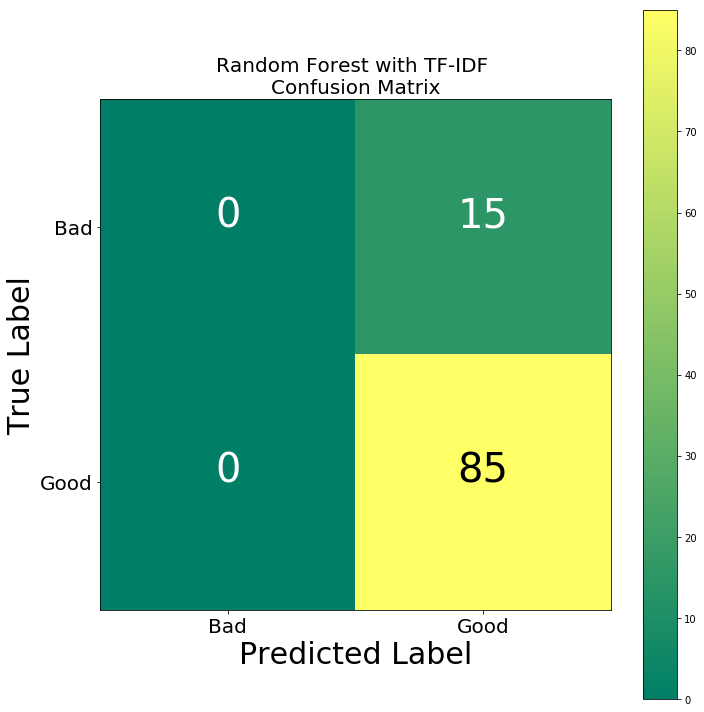

In [46]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

### 4.2.3 Naive Bayes with TF-IDF

In [47]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.781081081081081


**Classification Report**

In [48]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.85      1.00      0.92        85

   micro avg       0.85      0.85      0.85       100
   macro avg       0.42      0.50      0.46       100
weighted avg       0.72      0.85      0.78       100



**Confusion Matrix**

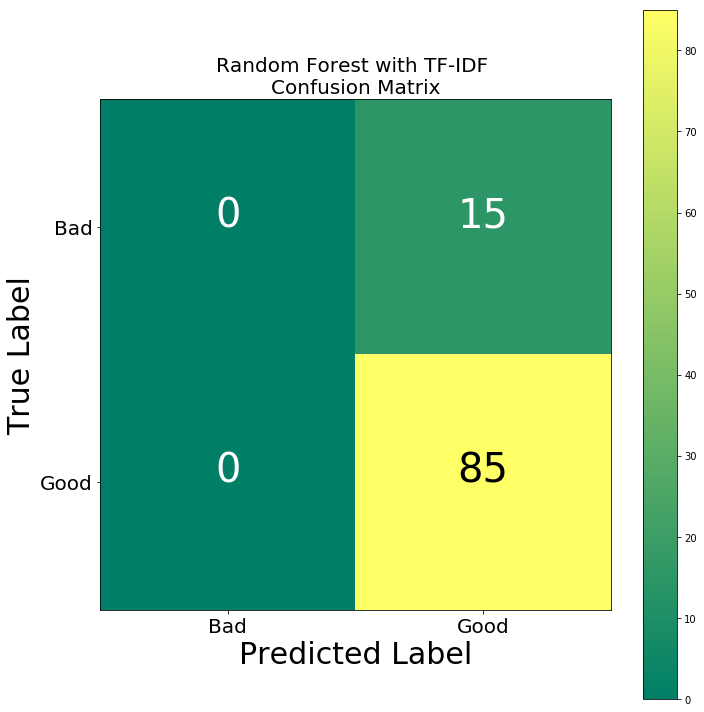

In [49]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Random Forest", "TF-IDF")

### 4.2.4 XGBoost with TF-IDF

In [50]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

f1 score: 0.8111369584181449


**Classification Report**

In [51]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.50      0.13      0.21        15
           1       0.86      0.98      0.92        85

   micro avg       0.85      0.85      0.85       100
   macro avg       0.68      0.55      0.56       100
weighted avg       0.81      0.85      0.81       100



**Confusion Matrix**

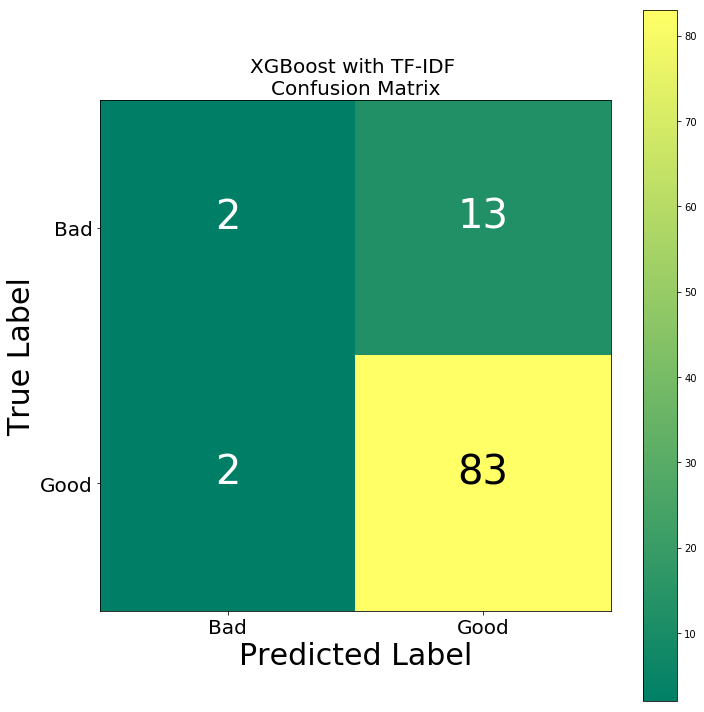

In [52]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")

### 4.2.5 Catboosting with TF-IDF

In [53]:
# Call the modeling function for Catboost with TF-IDF and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_catboost = y_pred

0:	learn: 0.3946229	total: 35.5ms	remaining: 53.2s
1:	learn: 0.3249930	total: 72.1ms	remaining: 54s
2:	learn: 0.3169049	total: 108ms	remaining: 54s
3:	learn: 0.3007971	total: 144ms	remaining: 53.7s
4:	learn: 0.2689435	total: 179ms	remaining: 53.4s
5:	learn: 0.2619832	total: 214ms	remaining: 53.4s
6:	learn: 0.2424135	total: 251ms	remaining: 53.6s
7:	learn: 0.2269363	total: 287ms	remaining: 53.6s
8:	learn: 0.2070540	total: 323ms	remaining: 53.5s
9:	learn: 0.2036825	total: 358ms	remaining: 53.4s
10:	learn: 0.1960631	total: 395ms	remaining: 53.4s
11:	learn: 0.1869962	total: 430ms	remaining: 53.3s
12:	learn: 0.1790565	total: 467ms	remaining: 53.4s
13:	learn: 0.1767740	total: 503ms	remaining: 53.4s
14:	learn: 0.1667976	total: 540ms	remaining: 53.5s
15:	learn: 0.1650140	total: 576ms	remaining: 53.4s
16:	learn: 0.1632921	total: 612ms	remaining: 53.4s
17:	learn: 0.1631439	total: 654ms	remaining: 53.9s
18:	learn: 0.1539953	total: 693ms	remaining: 54s
19:	learn: 0.1536482	total: 732ms	remaining: 

161:	learn: 0.0065703	total: 6.05s	remaining: 50s
162:	learn: 0.0063481	total: 6.08s	remaining: 49.9s
163:	learn: 0.0062996	total: 6.12s	remaining: 49.9s
164:	learn: 0.0062131	total: 6.16s	remaining: 49.8s
165:	learn: 0.0060161	total: 6.2s	remaining: 49.8s
166:	learn: 0.0059460	total: 6.23s	remaining: 49.7s
167:	learn: 0.0057841	total: 6.26s	remaining: 49.7s
168:	learn: 0.0057228	total: 6.3s	remaining: 49.6s
169:	learn: 0.0057156	total: 6.33s	remaining: 49.6s
170:	learn: 0.0056717	total: 6.37s	remaining: 49.5s
171:	learn: 0.0054755	total: 6.41s	remaining: 49.5s
172:	learn: 0.0054098	total: 6.44s	remaining: 49.4s
173:	learn: 0.0053268	total: 6.48s	remaining: 49.4s
174:	learn: 0.0053140	total: 6.51s	remaining: 49.3s
175:	learn: 0.0051129	total: 6.55s	remaining: 49.3s
176:	learn: 0.0050013	total: 6.58s	remaining: 49.2s
177:	learn: 0.0047801	total: 6.62s	remaining: 49.2s
178:	learn: 0.0047088	total: 6.65s	remaining: 49.1s
179:	learn: 0.0046349	total: 6.69s	remaining: 49.1s
180:	learn: 0.00

320:	learn: 0.0020341	total: 11.8s	remaining: 43.3s
321:	learn: 0.0020339	total: 11.8s	remaining: 43.2s
322:	learn: 0.0020321	total: 11.8s	remaining: 43.2s
323:	learn: 0.0020239	total: 11.9s	remaining: 43.1s
324:	learn: 0.0020017	total: 11.9s	remaining: 43.1s
325:	learn: 0.0019943	total: 12s	remaining: 43s
326:	learn: 0.0019907	total: 12s	remaining: 43s
327:	learn: 0.0019820	total: 12s	remaining: 43s
328:	learn: 0.0019602	total: 12.1s	remaining: 42.9s
329:	learn: 0.0019596	total: 12.1s	remaining: 42.9s
330:	learn: 0.0019512	total: 12.1s	remaining: 42.8s
331:	learn: 0.0019498	total: 12.2s	remaining: 42.8s
332:	learn: 0.0019468	total: 12.2s	remaining: 42.8s
333:	learn: 0.0019435	total: 12.2s	remaining: 42.7s
334:	learn: 0.0019403	total: 12.3s	remaining: 42.7s
335:	learn: 0.0019394	total: 12.3s	remaining: 42.6s
336:	learn: 0.0019323	total: 12.3s	remaining: 42.6s
337:	learn: 0.0019193	total: 12.4s	remaining: 42.6s
338:	learn: 0.0019193	total: 12.4s	remaining: 42.5s
339:	learn: 0.0019020	to

480:	learn: 0.0013469	total: 17.4s	remaining: 36.9s
481:	learn: 0.0013428	total: 17.4s	remaining: 36.8s
482:	learn: 0.0013417	total: 17.5s	remaining: 36.8s
483:	learn: 0.0013374	total: 17.5s	remaining: 36.8s
484:	learn: 0.0013330	total: 17.5s	remaining: 36.7s
485:	learn: 0.0013294	total: 17.6s	remaining: 36.7s
486:	learn: 0.0013282	total: 17.6s	remaining: 36.6s
487:	learn: 0.0013271	total: 17.6s	remaining: 36.6s
488:	learn: 0.0013269	total: 17.7s	remaining: 36.6s
489:	learn: 0.0013187	total: 17.7s	remaining: 36.5s
490:	learn: 0.0013163	total: 17.8s	remaining: 36.5s
491:	learn: 0.0013159	total: 17.8s	remaining: 36.5s
492:	learn: 0.0013124	total: 17.8s	remaining: 36.4s
493:	learn: 0.0013103	total: 17.9s	remaining: 36.4s
494:	learn: 0.0013049	total: 17.9s	remaining: 36.3s
495:	learn: 0.0013042	total: 17.9s	remaining: 36.3s
496:	learn: 0.0013014	total: 18s	remaining: 36.3s
497:	learn: 0.0012984	total: 18s	remaining: 36.2s
498:	learn: 0.0012977	total: 18s	remaining: 36.2s
499:	learn: 0.0012

639:	learn: 0.0009883	total: 23s	remaining: 30.9s
640:	learn: 0.0009880	total: 23s	remaining: 30.9s
641:	learn: 0.0009861	total: 23.1s	remaining: 30.8s
642:	learn: 0.0009857	total: 23.1s	remaining: 30.8s
643:	learn: 0.0009851	total: 23.2s	remaining: 30.8s
644:	learn: 0.0009840	total: 23.2s	remaining: 30.7s
645:	learn: 0.0009838	total: 23.2s	remaining: 30.7s
646:	learn: 0.0009824	total: 23.3s	remaining: 30.7s
647:	learn: 0.0009823	total: 23.3s	remaining: 30.6s
648:	learn: 0.0009754	total: 23.3s	remaining: 30.6s
649:	learn: 0.0009714	total: 23.4s	remaining: 30.6s
650:	learn: 0.0009703	total: 23.4s	remaining: 30.6s
651:	learn: 0.0009689	total: 23.5s	remaining: 30.5s
652:	learn: 0.0009681	total: 23.5s	remaining: 30.5s
653:	learn: 0.0009656	total: 23.6s	remaining: 30.5s
654:	learn: 0.0009552	total: 23.6s	remaining: 30.4s
655:	learn: 0.0009513	total: 23.6s	remaining: 30.4s
656:	learn: 0.0009505	total: 23.7s	remaining: 30.4s
657:	learn: 0.0009498	total: 23.7s	remaining: 30.3s
658:	learn: 0.00

798:	learn: 0.0008255	total: 28.9s	remaining: 25.3s
799:	learn: 0.0008238	total: 28.9s	remaining: 25.3s
800:	learn: 0.0008235	total: 28.9s	remaining: 25.3s
801:	learn: 0.0008212	total: 29s	remaining: 25.2s
802:	learn: 0.0008203	total: 29s	remaining: 25.2s
803:	learn: 0.0008203	total: 29.1s	remaining: 25.1s
804:	learn: 0.0008200	total: 29.1s	remaining: 25.1s
805:	learn: 0.0008198	total: 29.1s	remaining: 25.1s
806:	learn: 0.0008197	total: 29.2s	remaining: 25s
807:	learn: 0.0008194	total: 29.2s	remaining: 25s
808:	learn: 0.0008186	total: 29.2s	remaining: 25s
809:	learn: 0.0008183	total: 29.3s	remaining: 24.9s
810:	learn: 0.0008183	total: 29.3s	remaining: 24.9s
811:	learn: 0.0008175	total: 29.3s	remaining: 24.9s
812:	learn: 0.0008173	total: 29.4s	remaining: 24.8s
813:	learn: 0.0008148	total: 29.4s	remaining: 24.8s
814:	learn: 0.0008147	total: 29.4s	remaining: 24.7s
815:	learn: 0.0008145	total: 29.5s	remaining: 24.7s
816:	learn: 0.0008132	total: 29.5s	remaining: 24.7s
817:	learn: 0.0008128	

957:	learn: 0.0007548	total: 34.7s	remaining: 19.6s
958:	learn: 0.0007547	total: 34.8s	remaining: 19.6s
959:	learn: 0.0007540	total: 34.8s	remaining: 19.6s
960:	learn: 0.0007530	total: 34.9s	remaining: 19.6s
961:	learn: 0.0007530	total: 34.9s	remaining: 19.5s
962:	learn: 0.0007530	total: 35s	remaining: 19.5s
963:	learn: 0.0007529	total: 35s	remaining: 19.5s
964:	learn: 0.0007528	total: 35s	remaining: 19.4s
965:	learn: 0.0007524	total: 35.1s	remaining: 19.4s
966:	learn: 0.0007524	total: 35.1s	remaining: 19.4s
967:	learn: 0.0007510	total: 35.2s	remaining: 19.3s
968:	learn: 0.0007510	total: 35.2s	remaining: 19.3s
969:	learn: 0.0007507	total: 35.3s	remaining: 19.3s
970:	learn: 0.0007507	total: 35.3s	remaining: 19.2s
971:	learn: 0.0007507	total: 35.4s	remaining: 19.2s
972:	learn: 0.0007507	total: 35.4s	remaining: 19.2s
973:	learn: 0.0007506	total: 35.4s	remaining: 19.1s
974:	learn: 0.0007506	total: 35.5s	remaining: 19.1s
975:	learn: 0.0007504	total: 35.5s	remaining: 19.1s
976:	learn: 0.0007

1114:	learn: 0.0007186	total: 40.9s	remaining: 14.1s
1115:	learn: 0.0007185	total: 40.9s	remaining: 14.1s
1116:	learn: 0.0007182	total: 40.9s	remaining: 14s
1117:	learn: 0.0007179	total: 41s	remaining: 14s
1118:	learn: 0.0007173	total: 41s	remaining: 14s
1119:	learn: 0.0007172	total: 41s	remaining: 13.9s
1120:	learn: 0.0007170	total: 41.1s	remaining: 13.9s
1121:	learn: 0.0007170	total: 41.1s	remaining: 13.9s
1122:	learn: 0.0007170	total: 41.2s	remaining: 13.8s
1123:	learn: 0.0007169	total: 41.2s	remaining: 13.8s
1124:	learn: 0.0007168	total: 41.2s	remaining: 13.7s
1125:	learn: 0.0007168	total: 41.3s	remaining: 13.7s
1126:	learn: 0.0007166	total: 41.3s	remaining: 13.7s
1127:	learn: 0.0007164	total: 41.3s	remaining: 13.6s
1128:	learn: 0.0007163	total: 41.4s	remaining: 13.6s
1129:	learn: 0.0007161	total: 41.4s	remaining: 13.6s
1130:	learn: 0.0007161	total: 41.5s	remaining: 13.5s
1131:	learn: 0.0007160	total: 41.5s	remaining: 13.5s
1132:	learn: 0.0007145	total: 41.5s	remaining: 13.5s
1133:

1270:	learn: 0.0006625	total: 46.8s	remaining: 8.43s
1271:	learn: 0.0006625	total: 46.8s	remaining: 8.39s
1272:	learn: 0.0006625	total: 46.8s	remaining: 8.35s
1273:	learn: 0.0006625	total: 46.9s	remaining: 8.31s
1274:	learn: 0.0006625	total: 46.9s	remaining: 8.28s
1275:	learn: 0.0006624	total: 47s	remaining: 8.24s
1276:	learn: 0.0006623	total: 47s	remaining: 8.21s
1277:	learn: 0.0006623	total: 47s	remaining: 8.17s
1278:	learn: 0.0006623	total: 47.1s	remaining: 8.13s
1279:	learn: 0.0006623	total: 47.1s	remaining: 8.1s
1280:	learn: 0.0006613	total: 47.1s	remaining: 8.06s
1281:	learn: 0.0006600	total: 47.2s	remaining: 8.02s
1282:	learn: 0.0006596	total: 47.2s	remaining: 7.99s
1283:	learn: 0.0006596	total: 47.3s	remaining: 7.95s
1284:	learn: 0.0006596	total: 47.3s	remaining: 7.91s
1285:	learn: 0.0006596	total: 47.3s	remaining: 7.88s
1286:	learn: 0.0006586	total: 47.4s	remaining: 7.84s
1287:	learn: 0.0006561	total: 47.4s	remaining: 7.8s
1288:	learn: 0.0006561	total: 47.4s	remaining: 7.77s
1

1426:	learn: 0.0006203	total: 52.7s	remaining: 2.69s
1427:	learn: 0.0006198	total: 52.7s	remaining: 2.66s
1428:	learn: 0.0006198	total: 52.7s	remaining: 2.62s
1429:	learn: 0.0006198	total: 52.8s	remaining: 2.58s
1430:	learn: 0.0006198	total: 52.8s	remaining: 2.55s
1431:	learn: 0.0006197	total: 52.9s	remaining: 2.51s
1432:	learn: 0.0006197	total: 52.9s	remaining: 2.47s
1433:	learn: 0.0006197	total: 52.9s	remaining: 2.44s
1434:	learn: 0.0006196	total: 53s	remaining: 2.4s
1435:	learn: 0.0006191	total: 53s	remaining: 2.36s
1436:	learn: 0.0006189	total: 53.1s	remaining: 2.33s
1437:	learn: 0.0006189	total: 53.1s	remaining: 2.29s
1438:	learn: 0.0006189	total: 53.1s	remaining: 2.25s
1439:	learn: 0.0006189	total: 53.2s	remaining: 2.21s
1440:	learn: 0.0006189	total: 53.2s	remaining: 2.18s
1441:	learn: 0.0006189	total: 53.2s	remaining: 2.14s
1442:	learn: 0.0006177	total: 53.3s	remaining: 2.1s
1443:	learn: 0.0006177	total: 53.3s	remaining: 2.07s
1444:	learn: 0.0006177	total: 53.4s	remaining: 2.03s

**Classification Report**

In [54]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_catboost))

              precision    recall  f1-score   support

           0       0.71      0.33      0.45        15
           1       0.89      0.98      0.93        85

   micro avg       0.88      0.88      0.88       100
   macro avg       0.80      0.65      0.69       100
weighted avg       0.87      0.88      0.86       100



**Confusion Matrix**

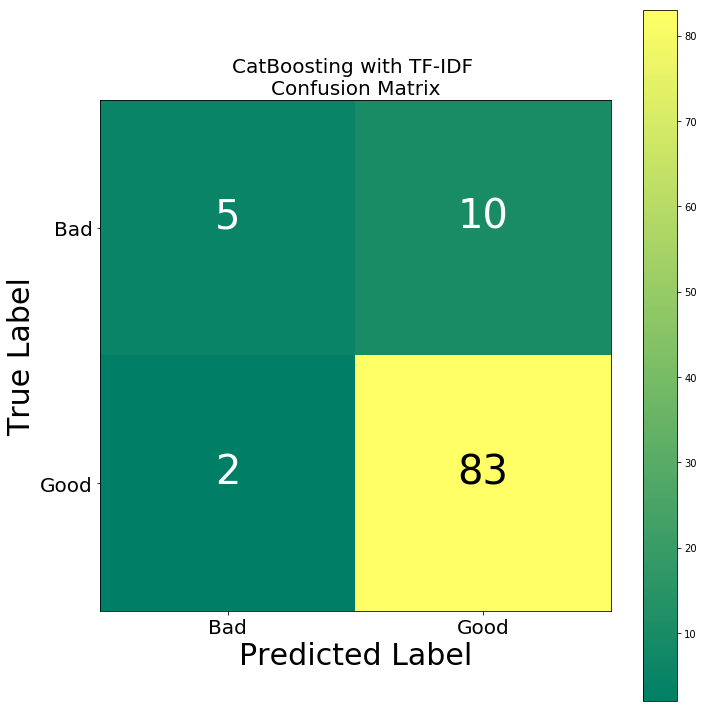

In [55]:
# Print confusion matrix for CatBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_catboost, "CatBoosting", "TF-IDF")

### 4.2.6 Comparision of TF-IDF Vectorizing

In [56]:
#For loop for using "comparison functions" on "TfidfVectorizing" results

frames_tv = [] # empty list for collecting dataframes
y_preds_tv = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, 
              y_pred_tfidf_xgb, y_pred_tfidf_catboost] #list for y_preds
labels_tv = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'] # list for labels
vector_tv = 'TfidfVect'
for y_pred, label in zip(y_preds_tv, labels_tv):
    df = comparison_matrix(y_test, y_pred, label, vector_tv)
    frames_tv.append(df)

# concatenating all dataframes
df_tv = pd.concat(frames_tv)

df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

**Comparison Table - TF-IDF Vectorizing**

In [57]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with TfidfVectorizing\n')
df_tv2


Comparision Matrix of Modeling with TfidfVectorizing



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
TfidfVect  LogReg        0.86     bad       0.545455  0.400000  0.461538   
                                  good      0.898876  0.941176  0.919540   
                                  average   0.845863  0.860000  0.850840   
           Random Forest 0.85     bad       0.000000  0.000000  0.000000   
                                  good      0.850000  1.000000  0.918919   
                                  average   0.722500  0.850000  0.781081   
           Naive Bayes   0.85     bad       0.000000  0.000000  0.000000   
                                  good      0.850000  1.000000  0.918919   
                                  average   0.722500  0.850000  0.781081   
           XGBoost       0.85     bad       0.500000  0.133333  0.210526   
                                  good      0.864583  0.976471  0.917127   
                                  average   0.809896  0.850000  0.811137   
           CatBoost      0.88     bad       0.714286  0.333333  0.454545   
                                  good      0.892473  0.976471  0.932584   
                                  average   0.865745  0.880000  0.860878   

                                           support  
vectorizer model         accuracy class             
TfidfVect  LogReg        0.86     bad         15.0  
                                  good        85.0  
                                  average    100.0  
           Random Forest 0.85     bad         15.0  
                                  good        85.0  
                                  average    100.0  
           Naive Bayes   0.85     bad         15.0  
                                  good        85.0  
                                  average    100.0  
           XGBoost       0.85     bad         15.0  
                                  good        85.0  
                                  average    100.0  
           CatBoost      0.88     bad         15.0  
                                  good        85.0  
                                  average    100.0

**Average f1 score - TF-IDF Vectorizing**

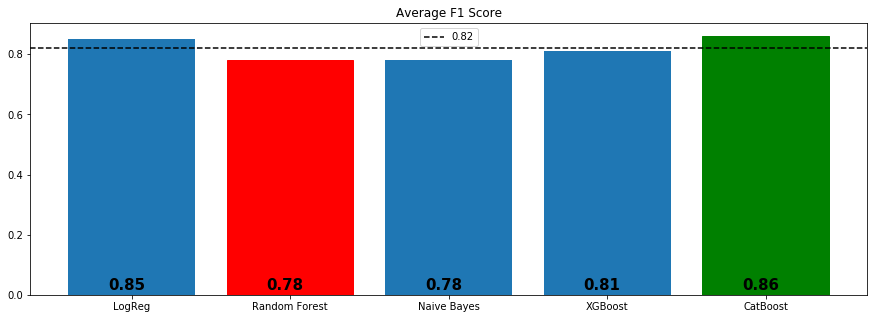

In [58]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")